In [ ]:
#Project 1 by Eddie Conti.
import numpy as np
import scipy
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

np.random.seed(42)

#We start with C1 and C2.

def solKKT(M,rl,ra,rc,rs,n,m,p):
  right_hand= np.concatenate((-rl,-ra,- rc,-rs), axis=0)
  delta=np.linalg.solve(M, right_hand)
  dx,dgam,dlamb,ds=delta[:n],delta[n:n+p],delta[n+p:n+p+m],delta[-m:]
  return dx,dgam,dlamb,ds

def Newton_step(lamb0,dlamb,s0,ds):
  alp=1;
  idx_lamb0 = [i for i, x in enumerate(dlamb) if x < 0]
  if len(idx_lamb0)>0:
    alp = min(alp,np.min(-lamb0[idx_lamb0]/dlamb[idx_lamb0]))
  idx_s0=[i for i, x in enumerate(ds) if x < 0]
  if len(idx_s0)>0:
    alp = min(alp,np.min(-s0[idx_s0]/ds[idx_s0]))
  return alp

def step_size_substep(m,z0,n,p,ds,dlamb):
  lamb0,s0=z0[n+p:n+p+m],z0[-m:]
  mu=np.dot(np.transpose(s0),lamb0)/m
  mu_tilde=np.dot(np.transpose(s0+alp*ds),lamb0+alp*dlamb)/m
  sigma=(mu_tilde/mu)**3
  return mu, sigma

def creatematrix(G,A,C,n,p,m,z0):
  M=np.hstack((G,-A,-C, np.zeros((n,m))))
  M=np.vstack((M,np.hstack((-np.transpose(A),np.zeros((p,p)),np.zeros((p,m)),np.zeros((p,m))))))
  M=np.vstack((M,np.hstack((-np.transpose(C),np.zeros((m,p)),np.zeros((m,m)),np.eye(m)))))
  lamb0,s0=z0[n+p:n+p+m],z0[-m:]
  S,L=np.diag(s0),np.diag(lamb0)
  M=np.vstack((M,np.hstack((np.zeros((m,n)),np.zeros((m,p)),S,L))))
  return M

def evalfunc(z0,g,G,A,C,n,m,p,b,d): #This function computes the right-hand vector.
  rl=np.dot(G,z0[:n])+g-np.dot(A,z0[n:n+p])-np.dot(C,z0[n+p:n+p+m])
  ra=b-np.dot(np.transpose(A),z0[:n])
  rc=z0[-m:]+d-np.dot(np.transpose(C),z0[:n])
  rs=z0[n+p:n+p+m]*z0[-m:]
  return rl,ra,rc,rs

#TEST PROBLEM
n_iter=0
eps=10**(-16) #fixed precision for the algorithm
n=5 #just to test the problem and check the solution
def test_problem(n):
  m,p=2*n,0 #p=0 in this case
  G=np.eye(n)
  g=np.random.randn(n)
  d=-10*np.ones(m)
  z0=np.hstack((np.zeros(n),np.ones(2*m))) #We initialized the starting point.
  C=np.hstack((np.eye(n),-np.eye(n))) #We created the matrix C.
  A,b=np.zeros((n,p)),np.zeros(p) #they are 0 in this case
  M=creatematrix(G,A,C,n,p,m,z0)
  rl,ra,rc,rs=evalfunc(z0,g,G,A,C,n,m,p,b,d)
  return M,G,g,m,p,d,z0,C,A,b,rl,ra,rc,rs

M,G,g,m,p,d,z0,C,A,b,rl,ra,rc,rs= test_problem(n)
mu=1 #just for the first if.

while n_iter <= 100:
  if  np.linalg.norm(rl)<eps or np.linalg.norm(rc)<eps or np.linalg.norm(mu)<eps: #We remove the ra condition because A=0.
    break
  dx,dgam,dlamb,ds=solKKT(M,rl,ra,rc,rs,n,m,p)
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds) #lamb0=z0[n+p:n+p+m] and s0=z0[-m:]
  mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
  e=np.ones(m)
  Ds,Dlamb=np.diag(ds),np.diag(dlamb) #here we inizialize dlamb ds
  dx,dgam,dlamb,ds=solKKT(M,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p)
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds) #we have to perform again the step-size correction substep
  z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds)) #The new point
  M=creatematrix(G,A,C,n,p,m,z0) #here we update the matrix
  rl,ra,rc,rs=evalfunc(z0,g,G,A,C,n,m,p,b,d) #we update the right-hand parts.
  n_iter += 1

sol=z0[:n] #we store the solution or the last value computed

In [ ]:
g
print(g,sol) #Check if x=-g.

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337] [-0.49671415  0.1382643  -0.64768854 -1.52302986  0.23415337]


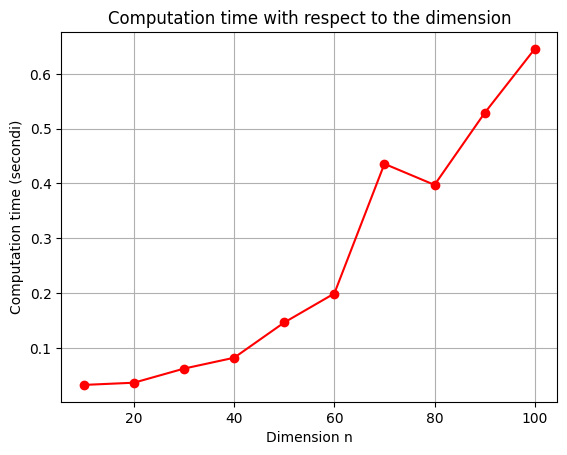

In [ ]:
#C3
#Here we write a modification to C2 to to report the computation time of the solution of the test problem for different dimensions n.
import matplotlib.pyplot as plt
import time

dimensions_n =[10,20,30,40,50,60,70,80,90,100] #we create the vector of dimensions
computation_times = [] #here we will store the computation times.
cond_number=[]
n_iter_ordinary=[]

for n in dimensions_n:
    #We execute the code C2 and we start counting the time.
    M,G,g,m,p,d,z0,C,A,b,rl,ra,rc,rs= test_problem(n)
    #cond_numer.append(np.linalg.cond(M))
    start_time = time.time()
    mu,n_iter=1,0

    while n_iter <=100 and np.linalg.norm(rl)>=eps and np.linalg.norm(ra)>=eps and np.linalg.norm(rc)>=eps and np.linalg.norm(mu)>=eps:
      dx,dgam,dlamb,ds=solKKT(M,rl,ra,rc,rs,n,m,p)
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds) #lamb0=z0[n+p:n+p+m] and s0=z0[-m:]
      mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
      e=np.ones(m)
      Ds,Dlamb=np.diag(ds),np.diag(dlamb)
      dx,dgam,dlamb,ds=solKKT(M,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p)
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
      z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
      M=creatematrix(G,A,C,n,p,m,z0)
      #cond_number.append(np.linalg.cond(M))
      rl,ra,rc,rs=evalfunc(z0,g,G,A,C,n,m,p,b,d) #we update the right-hand parts.
      n_iter += 1
    end_time = time.time()
    elapsed_time = end_time - start_time
    computation_times.append(elapsed_time)
    n_iter_ordinary.append(n_iter)

#We create the graphic
plt.plot(dimensions_n, computation_times, marker='o',color='r')
plt.title("Computation time with respect to the dimension")
plt.xlabel("Dimension n")
plt.ylabel("Computation time (secondi)")
plt.grid(True)
plt.show()







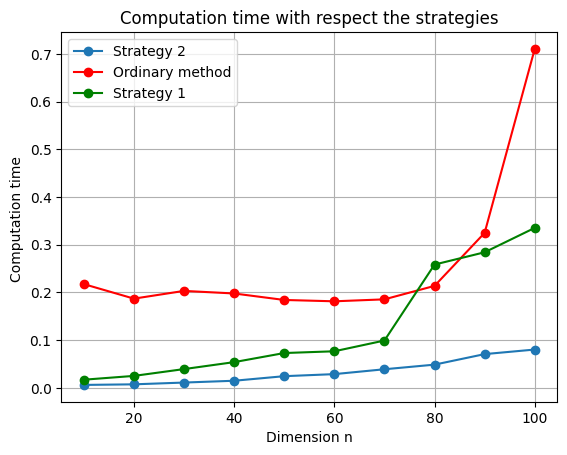

In [ ]:
#C4 Here two programs that solve the optimization problem for the test problem using the previous strategies and compare computational times.
#We store also the condition number of the initial matrix M, the relative error and the number of iteration for each case of n.

def strategy1(G,C,rl,ra,rc,rs,n,m,p,s0,lamb0):
  S=np.diag(s0) #we create the matrix S
  L1=np.diag(1/lamb0) #This \Lambda^{-1}
  #We compute the right matrix for the system.
  Mat=np.hstack((G,-C))
  Mat=np.vstack((Mat,np.hstack((-np.transpose(C),-np.dot(L1,S)))))
  #here we perform the solution with LDLDT factorization
  lu, d, perm =scipy.linalg.ldl(Mat, lower=True)
  right_hand= np.concatenate((-rl,-rc+np.dot(L1,rs)), axis=0)
  z=scipy.linalg.solve_triangular(lu,right_hand, lower=True) #solve Ly=r
  y=(1/np.diag(d))*z
  delta=scipy.linalg.solve_triangular(np.transpose(lu),y, lower=False)
  dx=delta[:n]
  dlamb=delta[n+p:n+p+m]
  ds=np.dot(L1,(-rs-np.dot(S,dlamb)))
  dgam=np.zeros(p) #we don't have it
  return dx,dgam,dlamb,ds


#We now implemenet the strategy2
def strategy2(G,C,rl,ra,rc,rs,n,m,p,s0,lamb0):
  S1=np.diag(1/s0) #we create the matrix S^{-1}
  L=np.diag(lamb0) #This \Lambda
  #here we perform the solution with LDLDT factorization
  Gt=G+np.dot(C,np.dot(S1,np.dot(L,np.transpose(C)))) #we compute $\Tilde{G}$
  rt=np.dot(np.dot(-C,S1),(-rs+np.dot(L,rc))) #here we defined the new right-hand and we solve \Tilde{G}\delta_x=-r_1-\tilde{r}
  #We apply cholesky factorization
  Lu=np.linalg.cholesky(Gt) #\Tilde{G}=LL^T now we solve the system.
  right_hand=-rl-rt
  y=scipy.linalg.solve_triangular(Lu,right_hand, lower=True) #solve Ly=r
  dx=scipy.linalg.solve_triangular(np.transpose(Lu),y)
  dlamb=np.dot(S1,(-rs+np.dot(L,rc)))-np.dot(np.dot(S1,np.dot(L,np.transpose(C))),dx) #Here we compute other solutions
  ds=-rc+np.dot(np.transpose(C),dx)
  dgam=np.zeros(p) #we don't have it
  return dx,dgam,dlamb,ds

dimensions_n =[10,20,30,40,50,60,70,80,90,100] #we create the vector of dimensions
computation_times_strategy2 = [] #here we will store the computation times.
n_iter_strategy2=[]
relerr_strategy2=[] #relative error strategy2

for n in dimensions_n:
    #We execute the code with strategy 2 and we start counting the time.
    start_time = time.time()
    M,G,g,m,p,d,z0,C,A,b,rl,ra,rc,rs= test_problem(n)
    mu=1 #to not create problems with the first if
    n_iter=0
    while n_iter <= 100:
      if  np.linalg.norm(rl)<eps or np.linalg.norm(rc)<eps or np.linalg.norm(mu)<eps: #We remove the ra condition because A=0.
        break
      dx,dgam,dlamb,ds=strategy2(G,C,rl,ra,rc,rs,n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds) #lamb0=z0[n+p:n+p+m] and s0=z0[-m:]
      mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
      e=np.ones(m)
      Ds=np.diag(ds) #here we inizialize dlamb ds
      Dlamb=np.diag(dlamb)
      dx,dgam,dlamb,ds=strategy2(G,C,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
      z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
      M=creatematrix(G,A,C,n,p,m,z0)
      rl,ra,rc,rs=evalfunc(z0,g,G,A,C,n,m,p,b,d)
      n_iter += 1
    end_time = time.time()
    elapsed_time = end_time - start_time
    computation_times_strategy2.append(elapsed_time)
    n_iter_strategy2.append(n_iter)
    relerr_strategy2.append(np.linalg.norm(z0[:n]+g)/np.linalg.norm(g)) #the solution is -g


#we create the vector of dimensions
computation_times_strategy1 = []
n_iter_strategy1=[]
cond_numer=[]
relerr_strategy1=[]  #relative error strategy 1

for n in dimensions_n:
    #We execute the code with strategy 2 and we start counting the time.
    start_time = time.time()
    M,G,g,m,p,d,z0,C,A,b,rl,ra,rc,rs= test_problem(n)
    mu,n_iter=1, 0
    while n_iter <=100 and np.linalg.norm(rl)>=eps and np.linalg.norm(ra)>=eps and np.linalg.norm(rc)>=eps and np.linalg.norm(mu)>=eps:
      dx,dgam,dlamb,ds=strategy1(G,C,rl,ra,rc,rs,n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds) #lamb0=z0[n+p:n+p+m] and s0=z0[-m:]
      mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
      e=np.ones(m)
      Ds,Dlamb=np.diag(ds),np.diag(dlamb)
      dx,dgam,dlamb,ds=strategy1(G,C,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
      z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
      M=creatematrix(G,A,C,n,p,m,z0)
      rl,ra,rc,rs=evalfunc(z0,g,G,A,C,n,m,p,b,d)
      n_iter += 1
    end_time = time.time()
    elapsed_time = end_time - start_time
    computation_times_strategy1.append(elapsed_time)
    n_iter_strategy1.append(n_iter)
    relerr_strategy1.append(np.linalg.norm(z0[:n]+g)/np.linalg.norm(g))


plt.plot(dimensions_n, computation_times_strategy2, marker='o', label='Strategy 2')
plt.plot(dimensions_n, computation_times, marker='o',color='r', label='Ordinary method')
plt.plot(dimensions_n, computation_times_strategy1, marker='o', color='g', label='Strategy 1')
plt.title("Computation time with respect the strategies")
plt.xlabel("Dimension n")
plt.ylabel("Computation time ")
plt.grid(True)
plt.legend()
plt.show()


relative error strategy 1 [3.6722974710030977e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
relative error strategy 2 [3.652322272827408e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


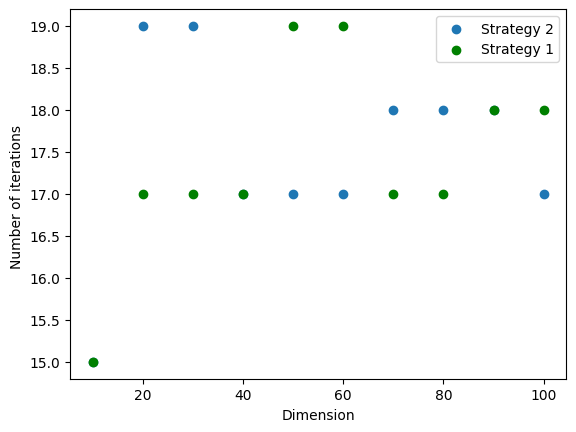

In [ ]:
print("relative error strategy 1", relerr_strategy1)
print("relative error strategy 2",relerr_strategy2)
plt.scatter(dimensions_n,  n_iter_strategy2, marker='o', label='Strategy 2')
plt.scatter(dimensions_n,  n_iter_strategy1, marker='o', color='g', label='Strategy 1')
plt.ylabel("Number of iterations ")
plt.xlabel("Dimension")
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [52]:
#C5 We test with the files provided. We have to import the matrices
from google.colab import drive
import pandas as pd
import time
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import coo_matrix, hstack, vstack, csr_matrix

#IMPORT THE DATA
drive.mount('/content/drive')
A_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/A.dad')
C_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/C.dad')
G_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/capital_G.dad')
b_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/b.dad')
d_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/d.dad')
g_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/g.dad')

# Transform data to numpy arrays
n,p,m=100,50,200 #Dimensions
G = coo_matrix((G_dad[:, 2], (G_dad[:, 0] - 1, G_dad[:, 1] - 1)), shape=(n, n))
A = coo_matrix((A_dad[:, 2], (A_dad[:, 0] - 1, A_dad[:, 1] - 1)), shape=(n, p))
C = coo_matrix((C_dad[:, 2], (C_dad[:, 0] - 1, C_dad[:, 1] - 1)), shape=(n, m))

G=G+G.T-scipy.sparse.tril(G, k=0) #Otherwise elements in the diagonal are doubled.

b,g,d = np.zeros(p),np.zeros(n),np.zeros(m)
#Desired form
b[(b_dad[:,0]-1).astype(int)] = b_dad[:,1]
g[(g_dad[:,0]-1).astype(int)] = g_dad[:,1]
d[(d_dad[:,0]-1).astype(int)] = d_dad[:,1]


n_iter,mu,eps=0,1,10**(-16)
z0=np.hstack((np.zeros(n),np.ones(p+2*m)))
condition_number=[]


def solKKTsparse(M,rl,ra,rc,rs,n,m,p):
  right_hand= np.concatenate((-rl,-ra,-rc,-rs))
  delta=scipy.sparse.linalg.spsolve(csr_matrix(M), right_hand)
  dx,dgam,dlamb,ds=delta[:n],delta[n:n+p],delta[n+p:n+p+m],delta[-m:]
  return dx,dgam,dlamb,ds

def evalfuncsparse(z0,g,G,A,C,n,m,p,b,d): #This function computes the right-hand vector.
  rl=G.dot(z0[:n])+g-A.dot(z0[n:n+p])-C.dot(z0[n+p:n+p+m])
  ra=b-(A.T).dot(z0[:n])
  rc=z0[-m:]+d-(C.T).dot(z0[:n])
  rs=z0[n+p:n+p+m]*z0[-m:]
  return rl,ra,rc,rs

def creatematrixsparse(G,A,C,n,p,m,z0):
  M=hstack((G,-A,-C, np.zeros((n,m))))
  M=vstack((M,hstack((-A.T,np.zeros((p,p)),np.zeros((p,m)),np.zeros((p,m))))))
  M=vstack((M,hstack((-C.T,np.zeros((m,p)),np.zeros((m,m)),np.eye(m)))))
  lamb0,s0=z0[n+p:n+p+m],z0[-m:]
  S,L=np.diag(s0),np.diag(lamb0)
  M=vstack((M,np.hstack((np.zeros((m,n)),np.zeros((m,p)),S,L)))) #M is a sparse matrix
  return M

M=creatematrixsparse(G,A,C,n,p,m,z0)
rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)
condition_number.append(np.linalg.cond(M.todense()))

start_time = time.time()
while n_iter <=100 and np.linalg.norm(rl)>=eps and np.linalg.norm(ra)>=eps and np.linalg.norm(rc)>=eps and np.linalg.norm(mu)>=eps:
  dx,dgam,dlamb,ds=solKKTsparse(M,rl,ra,rc,rs,n,m,p)
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
  e=np.ones(m)
  Ds,Dlamb=np.diag(ds),np.diag(dlamb)
  dx,dgam,dlamb,ds=solKKTsparse(M,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p)
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
  M=creatematrixsparse(G,A,C,n,p,m,z0)
  rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)
  condition_number.append(np.linalg.cond(M.todense()))
  n_iter += 1

end_time = time.time()
elapsed_time = end_time - start_time
sol=z0[:n]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
print(n_iter)
print(1/2*(sol.T.dot(G.dot(sol)))+g.T.dot(sol)) #Check the n_iteration and if the solution is correct
print(elapsed_time)

25
11590.718119426767
5.331813335418701


Text(0, 0.5, 'Condition number')

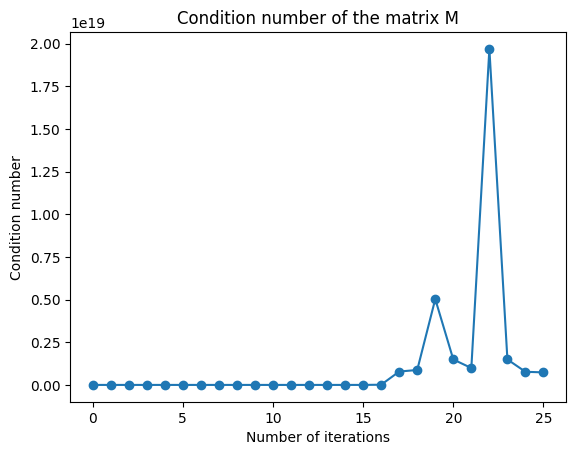

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(n_iter+1),condition_number,marker='o')
plt.title("Condition number of the matrix M")
plt.xlabel("Number of iterations")
plt.ylabel("Condition number")
#We observe that close to the solution the condition number explode.

In [49]:
#C5 second dataset.
n,p,m=1000,500,2000
n_iter,eps,mu=0,1e-14,1
z0=np.hstack((np.zeros(n),np.ones(p+2*m)))

A_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/A.dad')
C_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/C.dad')
G_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/G.dad')
b_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/b.dad')
d_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/d.dad')
g_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/g.dad')

# Transform data to numpy arrays
G = coo_matrix((G_dad[:, 2], (G_dad[:, 0] - 1, G_dad[:, 1] - 1)), shape=(n, n))
A = coo_matrix((A_dad[:, 2], (A_dad[:, 0] - 1, A_dad[:, 1] - 1)), shape=(n, p))
C = coo_matrix((C_dad[:, 2], (C_dad[:, 0] - 1, C_dad[:, 1] - 1)), shape=(n, m))
G=G+G.T-scipy.sparse.tril(G, k=0)

b,g,d = np.zeros(p),np.zeros(n),np.zeros(m)

b[(b_dad[:,0]-1).astype(int)] = b_dad[:,1]
g[(g_dad[:,0]-1).astype(int)] = g_dad[:,1]
d[(d_dad[:,0]-1).astype(int)] = d_dad[:,1]

M=creatematrixsparse(G,A,C,n,p,m,z0)
rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)


start_time = time.time()

while n_iter <=100 and np.linalg.norm(rl)>=eps and np.linalg.norm(ra)>=eps and np.linalg.norm(rc)>=eps and np.linalg.norm(mu)>=eps:
  dx,dgam,dlamb,ds=solKKTsparse(M,rl,ra,rc,rs,n,m,p)
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
  e=np.ones(m)
  Ds,Dlamb=np.diag(ds),np.diag(dlamb)
  dx,dgam,dlamb,ds=solKKTsparse(M,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p)
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
  M=creatematrixsparse(G,A,C,n,p,m,z0)
  rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)
  n_iter += 1

end_time = time.time()
elapsed_time = end_time - start_time
sol=z0[:n]

In [50]:
print(1/2*(sol.T.dot(G.dot(sol)))+g.T.dot(sol)) #The solution is correct.
print(n_iter)
print(elapsed_time)

1087511.567321501
32
72.85014653205872


In [23]:
#Here we perform the C6 code. The idea is to solve the previous problem using LDLT factorization. For stability reason, we have
#to work on the 2x2 blocks in d arising from scipy.linalg.ldl. We should detect the 2x2 block and solve the system for the 2x2 block
import scipy.sparse
from scipy.sparse import coo_matrix, hstack, vstack, csr_matrix
import time

#WE DEFINE TWO FUNCTIONS FOR THE DIAGONAL PART

def solve_system_with_2x2_blocks(D, right_hand, eps=1e-16):
    n = D.shape[0]
    x = np.zeros(n)
    for i in range(n):
        if i == n - 1:
            x[i] = right_hand[i] / D[i, i]
            break
        if abs(D[i, i + 1]) > eps or abs(D[i + 1, i]) > eps:
            # This is a 2x2 block
            sub_matrix = D[i:i+2, i:i+2]
            x[i:i+2]=scipy.linalg.solve(sub_matrix,right_hand[i:i+2])
            i+=1
        else:
            # This is a 1x1 block
            x[i] = right_hand[i] / D[i, i]
    return x

def fastblock(D, b): #solve Dx=b
  sub_diag = np.diag(D, k=-1)
  nonzero_indices = np.nonzero(sub_diag)[0]
  x = np.zeros(b.shape)
  mask = np.zeros(b.shape, dtype=bool)
  mask[nonzero_indices] = True
  for i in nonzero_indices:
      d_block = D[i:i+2, i:i+2]
      b_block = b[i:i+2]
      x_block = np.linalg.solve(d_block, b_block)
      x[i:i+2] = x_block
  x[~mask] = b[~mask] / D[~mask,~mask]
  return x

def creatematrixlast(G,A,C,n,p,m,z0):
  lamb0,s0=z0[n+p:n+p+m],z0[-m:]
  S=np.diag(s0)
  L1=np.diag(1/lamb0) #we create the matrix S and L^{-1}
  #We compute the right matrix for the system.
  M=hstack((G,-A,-C))
  M=vstack((M,hstack((-A.T,np.zeros((p,p)),np.zeros((p,m))))))
  M=vstack((M,hstack((-C.T,np.zeros((m,p)),-np.dot(L1,S)))))
  M=coo_matrix.todense(M) #So it is dense
  return M

cond_number_l=[]
cond_number_d=[]

def strategy3(M,rl,ra,rc,rs,n,m,p,lamb0,s0): #Final strategy for the last cases.
  S=np.diag(s0)
  L1=np.diag(1/lamb0) #we create the matrix S and L^{-1}
  lu, d, perm =scipy.linalg.ldl(M, lower=True)
  #cond_number_l.append(np.linalg.cond(lu))
  #cond_number_d.append(np.linalg.cond(d)) #I plotted the graph and then commented these line to take
  right_hand= np.concatenate((-rl,-ra,-rc+np.dot(L1,rs)), axis=0)
  z=scipy.linalg.solve_triangular(lu[perm,:],right_hand[perm], lower=True) #we solved properly the first part. Now we move to the diagonal part.
  sol=fastblock(d,z)
  I=np.eye(len(M))
  P=I[:,perm]
  temp_matrix=lu[perm,:]
  temp=scipy.linalg.solve_triangular(temp_matrix.T,sol,lower=False) #here you solve L^T*P^Tz=b
  delta=np.dot(P,temp) #we recollect the solution
  dx,dgam,dlamb=delta[:n],delta[n:n+p],delta[n+p:n+p+m]
  ds=L1.dot(-rs-S.dot(dlamb))
  return dx,dgam,dlamb,ds

A_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/A.dad')
C_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/C.dad')
G_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/capital_G.dad')
b_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/b.dad')
d_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/d.dad')
g_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr1-20231010/g.dad')


n,p,m=100,50,200 #Dimensions

G = coo_matrix((G_dad[:, 2], (G_dad[:, 0] - 1, G_dad[:, 1] - 1)), shape=(n, n))
A = coo_matrix((A_dad[:, 2], (A_dad[:, 0] - 1, A_dad[:, 1] - 1)), shape=(n, p))
C = coo_matrix((C_dad[:, 2], (C_dad[:, 0] - 1, C_dad[:, 1] - 1)), shape=(n, m))

G=G+G.T-scipy.sparse.tril(G, k=0) #Otherwise elements in the diagonal are doubled.

b,g,d = np.zeros(p),np.zeros(n),np.zeros(m)

b[(b_dad[:,0]-1).astype(int)] = b_dad[:,1]
g[(g_dad[:,0]-1).astype(int)] = g_dad[:,1]
d[(d_dad[:,0]-1).astype(int)] = d_dad[:,1]

n_iter,mu,eps=0,1,10**(-16)
z0=np.hstack((np.zeros(n),np.ones(p+2*m)))
M=creatematrixlast(G,A,C,n,p,m,z0)
rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)

start_time = time.time()
while n_iter <=100 and np.linalg.norm(rl)>=eps and np.linalg.norm(ra)>=eps and np.linalg.norm(rc)>=eps and np.linalg.norm(mu)>=eps:
  dx,dgam,dlamb,ds=strategy3(M,rl,ra,rc,rs,n,m,p,z0[n+p:n+p+m],z0[-m:])
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
  e=np.ones(m)
  Ds,Dlamb=np.diag(ds),np.diag(dlamb)
  dx,dgam,dlamb,ds=strategy3(M,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p,z0[n+p:n+p+m],z0[-m:])
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
  M=creatematrixlast(G,A,C,n,p,m,z0)
  rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)
  n_iter += 1

end_time = time.time()
elapsed_time = end_time - start_time
sol=z0[:n]


In [24]:
print(1/2*(sol.T.dot(G.dot(sol)))+g.T.dot(sol)) #The solution is correct.
print(n_iter)
print(elapsed_time)

11590.718119426765
32
1.899507999420166


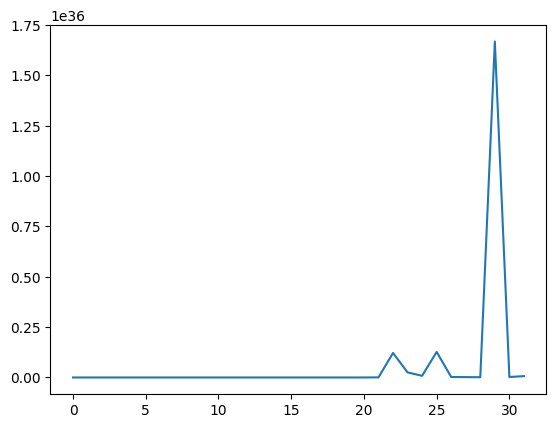

In [ ]:
plt.plot(np.arange(n_iter),cond_number_d[0::2]) #Here we detect the condition number of the diagonal matrix.
#We have to skip elements because we use strategy3 two times each iteration.
#Close to the solution we have higher values

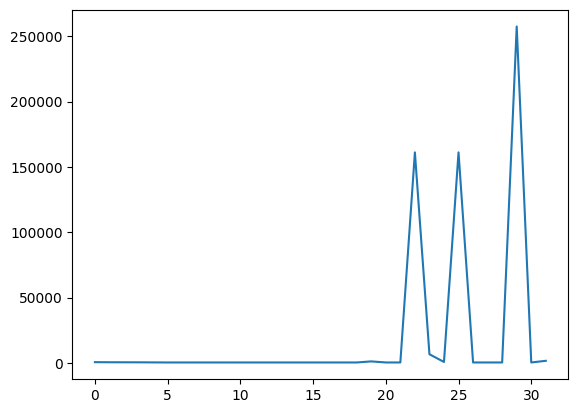

In [ ]:
plt.plot(np.arange(n_iter),cond_number_l[0::2]) #Same behaviour for lu


In [ ]:
z=scipy.linalg.solve_triangular(lu[perm,:],right_hand[perm], lower=True)
temp=solve_system_with_2x2_blocks(d,z)
I=np.eye(len(M))
P=I[:,perm]
temp_matrix=lu[perm,:]
delta=scipy.linalg.solve_triangular(temp_matrix.T,temp,lower=False)

In [ ]:
#THIS IS THE SECOND DATA. WE PERFORM THE SAME THINGS.

n,p,m=1000,500,2000
n_iter,eps,mu=0,1e-14,1

A_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/A.dad')
C_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/C.dad')
G_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/G.dad')
b_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/b.dad')
d_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/d.dad')
g_dad = np.loadtxt('/content/drive/My Drive/Project 1 NLA/optpr2-20231010/g.dad')

# Transform data to numpy arrays
G = coo_matrix((G_dad[:, 2], (G_dad[:, 0] - 1, G_dad[:, 1] - 1)), shape=(n, n))
A = coo_matrix((A_dad[:, 2], (A_dad[:, 0] - 1, A_dad[:, 1] - 1)), shape=(n, p))
C = coo_matrix((C_dad[:, 2], (C_dad[:, 0] - 1, C_dad[:, 1] - 1)), shape=(n, m))
G=G+G.T-scipy.sparse.tril(G, k=0)

b,g,d = np.zeros(p),np.zeros(n),np.zeros(m)

b[(b_dad[:,0]-1).astype(int)] = b_dad[:,1]
g[(g_dad[:,0]-1).astype(int)] = g_dad[:,1]
d[(d_dad[:,0]-1).astype(int)] = d_dad[:,1]


z0=np.hstack((np.zeros(n),np.ones(p+2*m)))
M=creatematrixlast(G,A,C,n,p,m,z0)
rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)


def strategytest(M,rl,ra,rc,rs,n,m,p,lamb0,s0): #USE THIS FUNCTION TO UNDERSTAND THE PROBLEM OF CODE C6 WITH THE SECOND DATASET
  S=np.diag(s0)
  L1=np.diag(1/lamb0) #we create the matrix S and L^{-1}
  lu, d, perm =scipy.linalg.ldl(M, lower=True)
  right_hand= np.concatenate((-rl,-ra,-rc+np.dot(L1,rs)), axis=0)
  #z=scipy.linalg.solve(lu,right_hand)
  z=scipy.linalg.solve(lu[perm,:],right_hand[perm], lower=True) #It still works---> see report 2.1 to better understand.
  sol=scipy.linalg.solve(d,z)
  I=np.eye(len(M))
  P=I[:,perm]
  temp_matrix=lu[perm,:]
  temp=scipy.linalg.solve_triangular(temp_matrix.T,sol,lower=False)
  delta=np.dot(P,temp)
  dx,dgam,dlamb=delta[:n],delta[n:n+p],delta[n+p:n+p+m]
  ds=L1.dot(-rs-S.dot(dlamb))
  return dx,dgam,dlamb,ds

while n_iter <=100 and np.linalg.norm(rl)>=eps and np.linalg.norm(ra)>=eps and np.linalg.norm(rc)>=eps and np.linalg.norm(mu)>=eps:
  dx,dgam,dlamb,ds=strategytest(M,rl,ra,rc,rs,n,m,p,z0[n+p:n+p+m],z0[-m:])
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
  e=np.ones(m)
  Ds,Dlamb=np.diag(ds),np.diag(dlamb)
  dx,dgam,dlamb,ds=strategytest(M,rl,ra,rc,rs+np.dot(Ds,np.dot(Dlamb,e))-np.dot(sigma,np.dot(mu,e)),n,m,p,z0[n+p:n+p+m],z0[-m:])
  alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
  z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
  M=creatematrixlast(G,A,C,n,p,m,z0)
  rl,ra,rc,rs=evalfuncsparse(z0,g,G,A,C,n,m,p,b,d)
  print(n_iter)
  sol=z0[:n]
  print(1/2*(sol.T.dot(G.dot(sol)))+g.T.dot(sol))
  n_iter += 1

sol=z0[:n]

In [42]:
#SOLUTION USING ONLY SCIPY.LINALG.SOLVE
print(n_iter)
print(1/2*(sol.T.dot(G.dot(sol)))+g.T.dot(sol))
#SOLUTION BY USING ONLY SCIPY.LINALG.SOLVE. 8 MIN OF COMPUTATION

33
1087511.5673215059


In [47]:
#HERE WE USED ALL THE CODE FROM STRATEGY 3 EXCEPT FOR sol=scipy.linalg.solve(d,z)
print(n_iter)
print(1/2*(sol.T.dot(G.dot(sol)))+g.T.dot(sol))
#THE COMPUTATION TIME IS 5 MIN 49 SECONDS.

30
1087511.5673215121


In [ ]:
#EXAMPLE OF CODE FOR LDLT WITHOUT USING scipy.ldl. This code was too slow to access.

def ldlt(A): #A is a symmetric matrix and here we compute the LDLT factorization
  n=len(A)
  L=np.identity(n)
  d=np.zeros(n)
  for j in range(len(A)):
      d[j]=A[j,j]
      for i in range(j+1,n):
        L[i,j]=A[i,j]/A[j,j] #we compute the matrix L by column
        for t in range(j+1,n):
          A[i,t]=A[i,t]-L[i,j]*A[j,t]
  return L,d

In [ ]:
#Here we check the condition number for the two strategies for n=50 and detect the behaviour.

def strategy1(G,C,rl,ra,rc,rs,n,m,p,s0,lamb0):
  S=np.diag(s0) #we create the matrix S
  L1=np.diag(1/lamb0) #This \Lambda^{-1}
  #We compute the right matrix for the system.
  Mat=np.hstack((G,-C))
  Mat=np.vstack((Mat,np.hstack((-np.transpose(C),-np.dot(L1,S)))))
  cond_number_strategy1.append(np.linalg.cond(Mat))
  #here we perform the solution with LDLDT factorization
  lu, d, perm =scipy.linalg.ldl(Mat, lower=True)
  right_hand= np.concatenate((-rl,-rc+np.dot(L1,rs)), axis=0)
  z=scipy.linalg.solve_triangular(lu,right_hand, lower=True) #solve Ly=r
  y=(1/np.diag(d))*z
  delta=scipy.linalg.solve_triangular(np.transpose(lu),y, lower=False)
  dx=delta[:n]
  dlamb=delta[n+p:n+p+m]
  ds=np.dot(L1,(-rs-np.dot(S,dlamb)))
  dgam=np.zeros(p) #we don't have it
  return dx,dgam,dlamb,ds,cond_number_strategy1


#We now implemenet the strategy2
def strategy2(G,C,rl,ra,rc,rs,n,m,p,s0,lamb0):
  S1=np.diag(1/s0) #we create the matrix S^{-1}
  L=np.diag(lamb0) #This \Lambda
  #here we perform the solution with LDLDT factorization
  Gt=G+np.dot(C,np.dot(S1,np.dot(L,np.transpose(C)))) #we compute $\Tilde{G}$
  cond_number_strategy2.append(np.linalg.cond(Gt))
  rt=np.dot(np.dot(-C,S1),(-rs+np.dot(L,rc))) #here we defined the new right-hand and we solve \Tilde{G}\delta_x=-r_1-\tilde{r}
  #We apply cholesky factorization
  Lu=np.linalg.cholesky(Gt) #\Tilde{G}=LL^T now we solve the system.
  right_hand=-rl-rt
  y=scipy.linalg.solve_triangular(Lu,right_hand, lower=True) #solve Ly=r
  dx=scipy.linalg.solve_triangular(np.transpose(Lu),y)
  dlamb=np.dot(S1,(-rs+np.dot(L,rc)))-np.dot(np.dot(S1,np.dot(L,np.transpose(C))),dx) #Here we compute other solutions
  ds=-rc+np.dot(np.transpose(C),dx)
  dgam=np.zeros(p) #we don't have it
  return dx,dgam,dlamb,ds,cond_number_strategy2


dimensions_n =[10,20,30,40,50,60,70,80,90,100] #we create the vector of dimensions
computation_times_strategy2 = [] #here we will store the computation times.
n_iter_strategy2=[]
relerr_strategy2=[]
cond_number_strategy2=[]

for n in dimensions_n:
    #We execute the code with strategy 2 and we start counting the time.
    start_time = time.time()
    M,G,g,m,p,d,z0,C,A,b,rl,ra,rc,rs= test_problem(n)
    mu=1 #to not create problems with the first if
    n_iter=0
    while n_iter <= 100:
      if  np.linalg.norm(rl)<eps or np.linalg.norm(rc)<eps or np.linalg.norm(mu)<eps: #We remove the ra condition because A=0.
        break
      dx,dgam,dlamb,ds,cond_number_strategy2=strategy2(G,C,rl,ra,rc,rs,n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds) #lamb0=z0[n+p:n+p+m] and s0=z0[-m:]
      mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
      e=np.ones(m)
      Ds=np.diag(ds) #here we inizialize dlamb ds
      Dlamb=np.diag(dlamb)
      dx,dgam,dlamb,ds,cond_number_strategy2=strategy2(G,C,rl,ra,rc,rs+(Ds*Dlamb*e-sigma*mu*e)[0],n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
      z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
      M=creatematrix(G,A,C,n,p,m,z0)
      rl,ra,rc,rs=evalfunc(z0,g,G,A,C,n,m,p,b,d)
      n_iter += 1
    end_time = time.time()
    elapsed_time = end_time - start_time
    computation_times_strategy2.append(elapsed_time)
    n_iter_strategy2.append(n_iter)
    relerr_strategy2.append(np.linalg.norm(z0[:n]+g)/np.linalg.norm(g)) #the solution is -g


#we create the vector of dimensions
computation_times_strategy1 = []
n_iter_strategy1=[]
cond_number_strategy1=[]
relerr_strategy1=[]  #relative error strategy 1

for n in dimensions_n:
    #We execute the code with strategy 2 and we start counting the time.
    start_time = time.time()
    M,G,g,m,p,d,z0,C,A,b,rl,ra,rc,rs= test_problem(n)
    mu,n_iter=1, 0
    while n_iter <= 100:
      if  np.linalg.norm(rl)<eps or np.linalg.norm(rc)<eps or np.linalg.norm(mu)<eps: #We remove the ra condition because A=0.
        break
      dx,dgam,dlamb,ds,cond_number_strategy1=strategy1(G,C,rl,ra,rc,rs,n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds) #lamb0=z0[n+p:n+p+m] and s0=z0[-m:]
      mu, sigma=step_size_substep(m,z0,n,p,ds,dlamb)
      e=np.ones(m)
      Ds,Dlamb=np.diag(ds),np.diag(dlamb)
      dx,dgam,dlamb,ds,cond_number_strategy1=strategy1(G,C,rl,ra,rc,rs+(Ds*Dlamb*e-sigma*mu*e)[0],n,m,p,z0[-m:],z0[n+p:n+p+m])
      alp=Newton_step(z0[n+p:n+p+m],dlamb,z0[-m:],ds)
      z0=z0+0.95*alp*np.concatenate((dx, dgam, dlamb, ds))
      M=creatematrix(G,A,C,n,p,m,z0)
      rl,ra,rc,rs=evalfunc(z0,g,G,A,C,n,m,p,b,d)
      n_iter += 1
    end_time = time.time()
    elapsed_time = end_time - start_time
    computation_times_strategy1.append(elapsed_time)
    n_iter_strategy1.append(n_iter)
    relerr_strategy1.append(np.linalg.norm(z0[:n]+g)/np.linalg.norm(g))


In [ ]:
cond_number_strategy1=cond_number_strategy1[0::2] #Because the matrix changes every two times.
sliced_cond_number_1= []
initial_start=0
for i in n_iter_strategy1:
    slice = cond_number_strategy1[initial_start:initial_start + i]
    sliced_cond_number_1.append(slice)
    initial_start += i

for i, slice in enumerate(sliced_cond_number_1):
    print(f"Condition number case {i+1}:", slice)

Condition number case 1: [1.7320508075688774, 9.981470324047342, 18.129852482432643, 1555.6408687334115, 4734.5995598251075, 24076.54335667331, 3183.6677965867857, 190.12943754244526, 21.540604592957084, 176.71243964405286, 1765.2464713896636, 34097.56403641667, 682096.2791208533, 13642071.16290954, 272841570.89057434, 5456832808.50725, 109136850189.32928, 2182914155583.9917, 43749119390663.49]
Condition number case 2: [1.7320508075688774, 9.810717081552507, 17.284446157523853, 1466.2117544668204, 29842.827890238867, 53834.55897185878, 3064.7533629074283, 163.61290297764228, 27.70739968808406, 309.90567353981464, 4437.983288370037, 87648.91561294456, 1753063.518463334, 35061355.65085882, 701227242.7987039, 14024561724.949411, 280497700357.3994, 5612224254714.166, 113564926994976.6, 2562480898874114.0, 3.818161067847157e+18]
Condition number case 3: [1.7320508075688774, 13.570440544201547, 24.89962039402632, 2015.0321122424905, 6716.0935709686155, 20559.711649344117, 2095.1846848576706,

In [ ]:
cond_number_strategy2=cond_number_strategy2[0::2]
sliced_cond_number_2= []
initial_start=0
for i in n_iter_strategy2:
    slice = cond_number_strategy2[initial_start:initial_start + i]
    sliced_cond_number_2.append(slice)
    initial_start += i

for i, slice in enumerate(sliced_cond_number_2):
    print(f"Condition number case {i+1}:", slice)

Condition number case 1: [1.0, 25.113085937029147, 1082.6063539448382, 2370.168783156944, 95147.6105756932, 11975.287941906701, 288.56682472677966, 1.6877919542564794, 2.3085407794659307, 1.1493722426931754, 1.0199865820265201, 1.0013030812469585, 1.0000665412007772, 1.0000033306932514, 1.0000001665437674, 1.0000000083272111, 1.0000000004163605, 1.000000000020818, 1.000000000001041, 1.000000000000052, 1.0000000000000027]
Condition number case 2: [1.0, 21.64569222635303, 918.2348848398199, 96424.18537795653, 72615.23687147906, 695219.4402378508, 77887.51287716968, 315.6706297606047, 1.6146642130408846, 1.9106540869393944, 1.143813652621732, 1.0211194532097878, 1.0014414624920074, 1.000073946916824, 1.0000037022906172, 1.0000001851269273, 1.0000000092563774, 1.000000000462819, 1.0000000000231408, 1.000000000001157, 1.0000000000000577, 1.0000000000000029]
Condition number case 3: [1.0, 23.951900949506822, 1013.2131594602151, 30996.6287063496, 217358.7294631421, 77270.23510641675, 1212.478